# Evaluación de los modelos

En este cuaderno se evaluarán los modelos entrenados previamente (Decision Tree, Random Forest, Logistic Regression).  
El objetivo es comparar su rendimiento en el conjunto de test y seleccionar el más adecuado.

 

# Libs

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)


# Cargar

## Modelos

In [2]:
models_dir = os.path.join("..", "models")

with open(os.path.join(models_dir, "modelo_random_forest_optimizado.pkl"), "rb") as f:
    rf_model = pickle.load(f)

with open(os.path.join(models_dir, "modelo_decision_tree_optimizado.pkl"), "rb") as f:
    dt_model = pickle.load(f)

with open(os.path.join(models_dir, "modelo_logistic_regression.pkl"), "rb") as f:
    log_model = pickle.load(f)

modelos = {
    "Random Forest": rf_model,
    "Decision Tree": dt_model,
    "Logistic Regression": log_model
}


## Datos

In [3]:
test_dir = os.path.join("..", "data", "test")

# Para Logistic Regression (datos escalados)
X_test_std = pd.read_csv(os.path.join(test_dir, "X_test_log.csv"))
y_test_std = pd.read_csv(os.path.join(test_dir, "Y_test_log.csv"))

# Para árboles (Decision Tree y Random Forest)
X_test_tree = pd.read_csv(os.path.join(test_dir, "X_test.csv"))
y_test_tree = pd.read_csv(os.path.join(test_dir, "Y_test.csv"))

# Evaluación

In [4]:
resultados = []

for nombre, modelo in modelos.items():
    if nombre == "Logistic Regression":
        X_eval, y_eval = X_test_std, y_test_std
    else:
        X_eval, y_eval = X_test_tree, y_test_tree
    
    y_pred = modelo.predict(X_eval)
    y_proba = modelo.predict_proba(X_eval)[:,1] if hasattr(modelo, "predict_proba") else None
    
    reporte = classification_report(y_eval, y_pred, output_dict=True)
    auc = roc_auc_score(y_eval, y_proba) if y_proba is not None else np.nan
    
    resultados.append({
        "Modelo": nombre,
        "Precision (Clase 1)": reporte['1']['precision'],
        "Recall (Clase 1)": reporte['1']['recall'],
        "F1-score (Clase 1)": reporte['1']['f1-score'],
        "ROC-AUC": auc
    })

df_resultados = pd.DataFrame(resultados)
display(df_resultados)


C:\Users\joang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\joang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,Modelo,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1),ROC-AUC
0,Random Forest,0.833333,0.845960,0.839599,0.920460
1,Decision Tree,0.721040,0.770202,0.744811,0.804848
2,Logistic Regression,0.661053,0.792929,0.721010,0.768489


##  Matrices de confusión

C:\Users\joang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


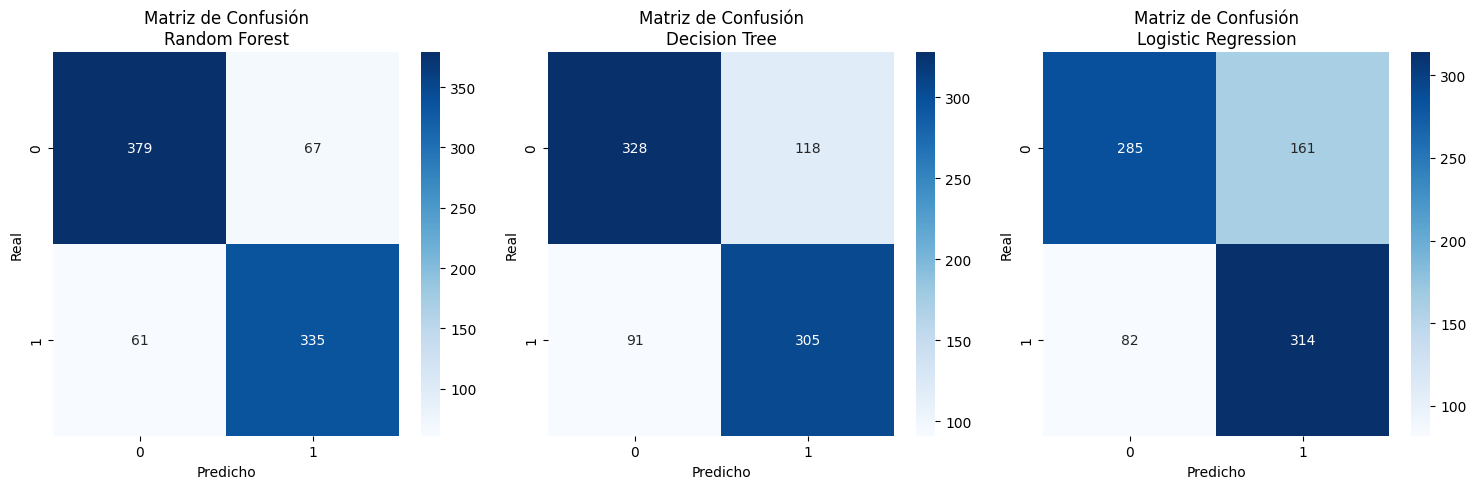

In [5]:
fig, axes = plt.subplots(1, len(modelos), figsize=(15,5))

for ax, (nombre, modelo) in zip(axes, modelos.items()):
    if nombre == "Logistic Regression":
        X_eval, y_eval = X_test_std, y_test_std
    else:
        X_eval, y_eval = X_test_tree, y_test_tree
    
    y_pred = modelo.predict(X_eval)
    cm = confusion_matrix(y_eval, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Matriz de Confusión\n{nombre}")
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.savefig("../reports/11-matrices_confusion_final.jpg", dpi=300, bbox_inches="tight")
plt.show()


- **Random Forest** es el modelo más equilibrado y preciso, mostrando la menor cantidad de errores.  
- **Decision Tree** ofrece un rendimiento aceptable pero con más errores en comparación.  
- **Logistic Regression** tiene una **alta tasa de falsos positivos**, lo que puede generar problemas si se penaliza en exceso a clientes no morosos.  


## Curvas ROC

C:\Users\joang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


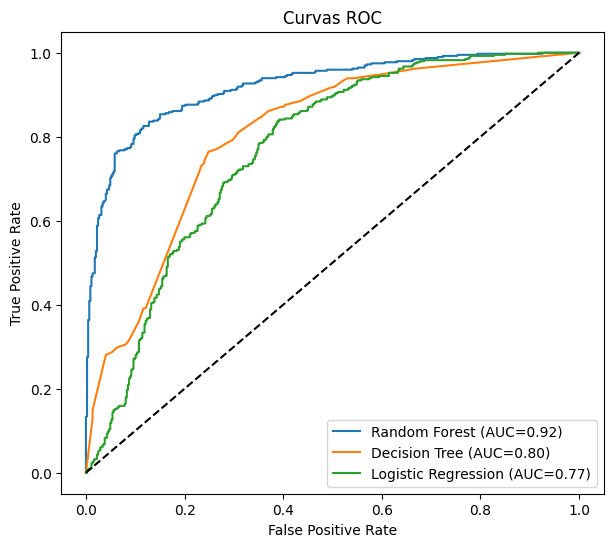

In [6]:
plt.figure(figsize=(7,6))

for nombre, modelo in modelos.items():
    if nombre == "Logistic Regression":
        X_eval, y_eval = X_test_std, y_test_std
    else:
        X_eval, y_eval = X_test_tree, y_test_tree
    
    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_eval)[:,1]
        fpr, tpr, _ = roc_curve(y_eval, y_proba)
        auc = roc_auc_score(y_eval, y_proba)
        plt.plot(fpr, tpr, label=f"{nombre} (AUC={auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC")
plt.legend()
plt.savefig("../reports/12-curvas_ROC.jpg", dpi=300, bbox_inches="tight")
plt.show()

- El **Random Forest es el modelo con mejor rendimiento global (AUC=0.92)**, mostrando una gran capacidad de clasificación en diferentes umbrales.  
- El **Decision Tree (AUC=0.80)** mantiene un rendimiento razonable, aunque menos estable.  
- La **Logistic Regression (AUC=0.77)** es el modelo menos efectivo en este contexto.  


## Comparativa AUC y F1-score

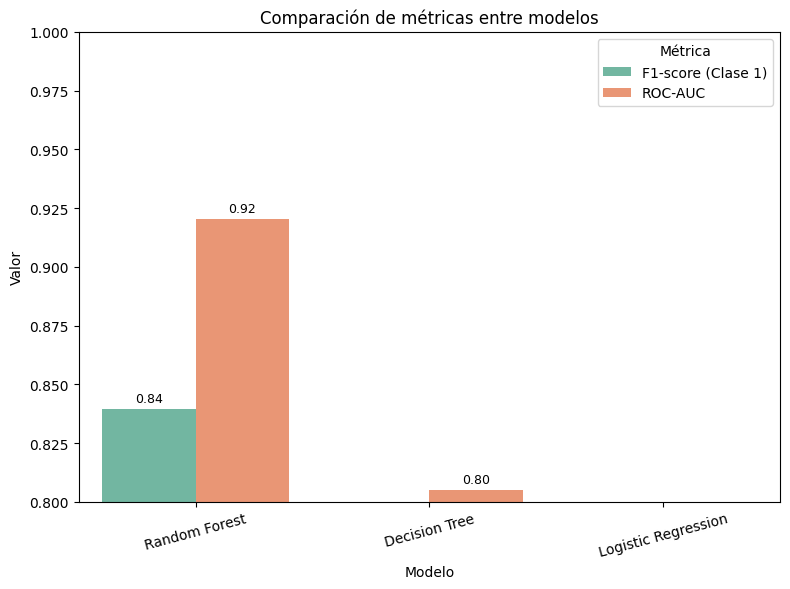

In [7]:
# Crear DataFrame con solo las métricas que queremos comparar
df_comparacion = df_resultados[["Modelo", "F1-score (Clase 1)", "ROC-AUC"]].melt(
    id_vars="Modelo",
    var_name="Métrica",
    value_name="Valor"
)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=df_comparacion, x="Modelo", y="Valor", hue="Métrica", palette="Set2")

# Añadir etiquetas de valor encima de cada barra
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=9, color="black", xytext=(0, 3), 
                textcoords="offset points")

# Ajustes de estilo
plt.title("Comparación de métricas entre modelos")
plt.ylabel("Valor")
plt.ylim(0.8, 1.0)
plt.legend(title="Métrica")
plt.xticks(rotation=15)
plt.tight_layout()

# Guardar la figura
plt.savefig("../reports/13-comparacion_auc_f1.jpg", dpi=300, bbox_inches="tight")
plt.show()



- El **Random Forest** es claramente el mejor modelo en términos de desempeño global, logrando un **AUC de 0.92** y un **F1-score de 0.84**, lo que lo convierte en la opción más robusta para la predicción de morosidad.  
- El **Decision Tree** puede ser útil por su interpretabilidad, pero no ofrece la misma capacidad predictiva.  
- La **Logistic Regression** queda descartada como opción principal al mostrar un rendimiento inferior.  


##  Curvas Precision-Recall

C:\Users\joang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


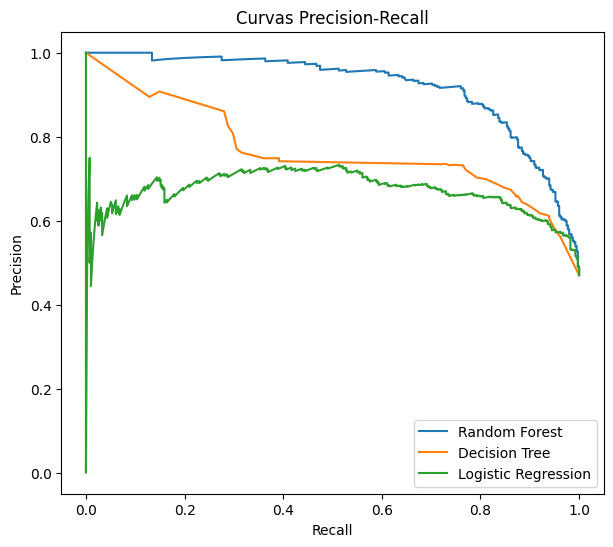

In [8]:
plt.figure(figsize=(7,6))

for nombre, modelo in modelos.items():
    if nombre == "Logistic Regression":
        X_eval, y_eval = X_test_std, y_test_std
    else:
        X_eval, y_eval = X_test_tree, y_test_tree
    
    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_eval)[:,1]
        precision, recall, _ = precision_recall_curve(y_eval, y_proba)
        plt.plot(recall, precision, label=nombre)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision-Recall")
plt.legend()
plt.savefig("../reports/14-curvas_precision_recall.jpg", dpi=300, bbox_inches="tight")
plt.show()

- **Random Forest**
  - Mantiene los valores de precisión más altos a lo largo de casi todo el rango de recall.
  - Esto indica que logra **detectar morosos sin sacrificar demasiada precisión**.
  - Su curva domina claramente sobre los otros dos modelos, confirmando su robustez.

- El **Random Forest** confirma su superioridad no solo en métricas globales (Accuracy, AUC), sino también en el **trade-off entre precisión y recall**, lo que lo convierte en la opción más adecuada para escenarios con desbalance de clases.  
- El **Decision Tree** ofrece un rendimiento aceptable, pero claramente inferior.  
- La **Logistic Regression** muestra el peor desempeño, siendo menos recomendable para la predicción de morosidad.


## Importancia de las variables

In [9]:
feat_importances = pd.DataFrame({
    "Variable": X_test_tree.columns,
    "Importancia RF": rf_model.feature_importances_,
    "Importancia DT": dt_model.feature_importances_
})
display(feat_importances.sort_values("Importancia RF", ascending=False).head(10))

,Variable,Importancia RF,Importancia DT
16,DIFERENCIA FECHA PRODUCCIÓN - 1ra CUOTA,0.099689,0.071783
8,ASESOR,0.096516,0.064757
2,IMPORTE INSCRIPCIÓN,0.084601,0.040840
1,FACTURACIÓN NETA,0.081950,0.060292
6,NUMERO DE CUOTAS,0.078734,0.038554
5,MEDIO PAGO IMPORTE PENDIENTE,0.077760,0.032005
12,PAÍS DE RESIDENCIA,0.072197,0.101698
11,NACIONALIDAD,0.067547,0.061659
17,% DTO,0.060530,0.039437
7,FORMA DE PAGO,0.060084,0.208805


- **Random Forest distribuye la importancia entre diversas variables económicas, comerciales y geográficas**, mostrando un modelo más equilibrado.  
- **Decision Tree concentra más peso en variables específicas** como la **forma de pago**, lo que lo hace más interpretable pero también más dependiente de pocas variables.  
- Variables clave en ambos modelos:  
  - **Asesor**  
  - **Importe de inscripción**  
  - **Facturación neta**  
  - **Nacionalidad**  

Estos resultados permiten identificar **factores críticos de riesgo de morosidad** y orientar estrategias de prevención (ej. revisar condiciones de inscripción, métodos de pago y políticas comerciales según país o asesor).  

# Conclusión

1. **Random Forest es el modelo más robusto y confiable**:  
   - Presenta la mejor precisión global (Accuracy ≈ 0.85).  
   - Obtiene el mayor equilibrio entre **precisión y recall** en ambas clases.  
   - Logra un **AUC de 0.92** en la curva ROC y un **F1-score de 0.84** para la clase morosos.  
   - En la curva Precision-Recall, mantiene valores altos y estables, confirmando su capacidad en un escenario de posible desbalance de clases.  

2. **Decision Tree ofrece interpretabilidad pero menor rendimiento**:  
   - Aunque logra resultados aceptables (Accuracy ≈ 0.75, AUC = 0.80), comete más errores que Random Forest.  
   - Su fortaleza radica en la **interpretabilidad**, siendo útil para explicar de manera sencilla las reglas de decisión.  

3. **Logistic Regression es el modelo más débil en este contexto**:  
   - Con un AUC de 0.77 y menor estabilidad en Precision-Recall, presenta más limitaciones para discriminar entre morosos y no morosos.  
   - No es recomendable como modelo principal.  

4. **Factores clave en la predicción de morosidad** (según la importancia de variables):  
   - **Diferencia en la fecha de producción**, **asesor**, **importe de inscripción**, **facturación neta**, y **nacionalidad**.  
   - Estos resultados permiten a la organización focalizar estrategias de prevención y control del riesgo.  
